# Análisis Espaciales (Parte 2)

## Clusterización con K-means
La clusterización de datos es una técnica de análisis en la que se agrupan objetos o datos similares en "clústers" o grupos. El objetivo principal de la clusterización es encontrar patrones o estructuras ocultas en los datos sin etiquetar, es decir, sin tener información previa sobre las categorías a las que pertenecen los objetos. La interesante de las clusterizaciones es la capacidad de resumir la información de muchas variables en un conjunto de clases reducidas. Además, estos métodos no requieren muchas suposiciones preliminares sobre la estructura de los datos, lo que la convierte en una herramienta exploratoria.

La forma en que cada observación es asignada a cada una de las clases difiere entre los distintos algoritmos de clusterización, en este caso expondremos la técnica K-means, que es probablemente la técnica mas utilizada de agrupamiento.

### Entendiendo K-means desde una perspectiva geográfica
El algoritmo k-means es una técnica popular de clusterización que busca dividir un conjunto de datos en k grupos o clústers. El algoritmo cuenta con los siguientes pasos:

1. **Inicialización**: Selecciona k centroides iniciales para los clústers. Estos centroides pueden ser seleccionados aleatoriamente o utilizando algún otro método, como k-means++.

2. **Asignación de Observaciones**: Asigna cada observación al centroide más cercano (cálculo de distancia), creando así k clústers iniciales.

3. **Actualización de Centroides**: Calcula los nuevos centroides para cada clúster tomando el promedio de las coordenadas de las observaciones asignadas a ese clúster.

4. **Reasignación de Puntos**: Vuelve a asignar cada observación al centroide más cercano (cálculo de distancia), utilizando los nuevos centroides calculados.

5. **Iteración**: Repite los pasos 2, 3 y 4 hasta que se alcance un número máximo de iteraciones establecido por el usuario; o hasta que se alcance la convergencia, es decir que los centroides ya no cambien significativamente

6. **Resultado Final**: Finalizado el paso 5, las observaciones estarán asignados a clústers y los centroides finales representarán los centros de esos clusters. 

Para conocer su implementación, veremos los pasos mencionados utilizando únicamente las variables X e Y, lo que implicaría una clusterización en función de la ubicación de las observaciones. Para el trabajo práctico final, incorporaremos más dimensiones a la clusterización. 

#### Paso 0 - Carga y preparación de datos

In [12]:
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
from owslib.wfs import WebFeatureService

# URL del servicio WFS que deseas consultar
wfs_url = "http://ide.pergamino.gob.ar:8080/geoserver/wfs" # IDE Pergamino

# Solicitud GetCapabilities al servicio WFS
wfs = WebFeatureService(wfs_url, version='1.0.0')

# GetFeature y Seteo de CRS
radios_censales = gpd.read_file(wfs.getfeature(typename=['radios_censales_indec_2010']))
radios_censales = radios_censales.set_crs('EPSG:5347')

radios_censales.explore()
# Elimino todas las variables excepto su geometría
#radios_censales = radios_censales[['geometry']]

# Muestra visualización simple
#radios_censales.plot(edgecolor='k', facecolor='none', figsize=(10, 8))

In [2]:
radios_censales.head()

,geometry
0,"POLYGON ((5446235.333 6250570.066, 5446324.284..."
1,"POLYGON ((5447556.668 6249828.883, 5447516.477..."
2,"POLYGON ((5424098.301 6288857.555, 5424168.801..."
3,"POLYGON ((5426720.301 6285501.555, 5426910.301..."
4,"POLYGON ((5467694.473 6275306.261, 5469688.468..."


#### Paso 1 - Inicialización

In [3]:
import random

# Cantidad de clúster a formar
num_cluster = 5

# Se generan tantos puntos aleatorios como clúster se quieran crear
## Para ello se establecen límites de radios
limites = radios_censales.total_bounds

## Se genera un listado aleatorio de coordenadas dentro de los límites
puntos_aleatorios = [(random.uniform(limites[0], limites[2]), random.uniform(limites[1], limites[3])) for i in range(num_cluster)]
puntos_aleatorios

[(5457369.071216317, 6270185.903727037),
 (5416898.917558452, 6278899.788189723),
 (5455439.688756492, 6265130.486121554),
 (5445484.424935244, 6228781.1065809075),
 (5458578.323919605, 6266816.539201599)]

<Axes: >

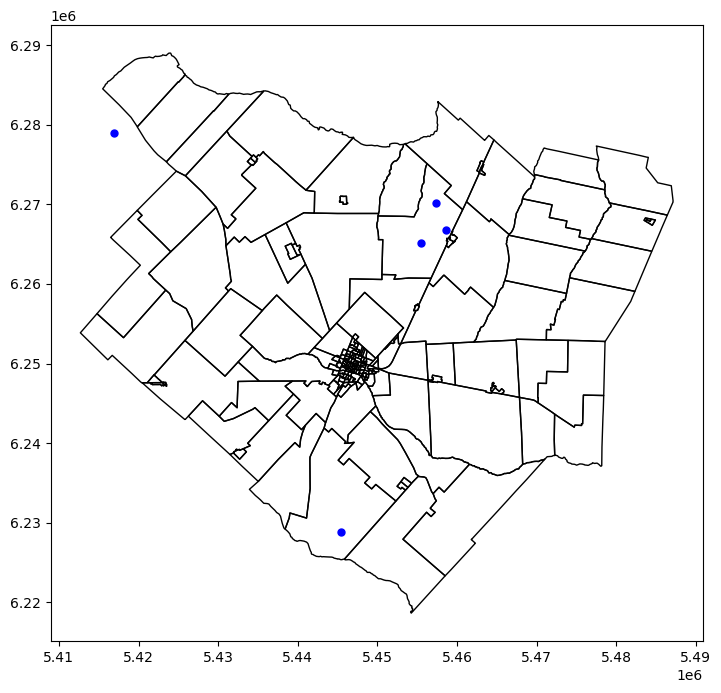

In [4]:
## Se crean las geometrías a partir de las coordenadas
from shapely.geometry import Point
geometrias_puntos = [Point(x, y) for x, y in puntos_aleatorios]

## Se crea un GeoDataFrame con las geometrías de punto (centroides de clústers)
centroides_clusters = gpd.GeoDataFrame(geometry=geometrias_puntos, crs=radios_censales.crs)

## Creamos un identificador para cada punto
centroides_clusters['cluster'] = centroides_clusters.index

# Mostramos ambos conjuntos de datos
ax = radios_censales.plot(edgecolor='k', facecolor='none', figsize=(10, 8))
centroides_clusters.plot(ax=ax, color='blue', markersize=25)

In [5]:
centroides_clusters.head()

,geometry,cluster
0,POINT (5457369.071 6270185.904),0
1,POINT (5416898.918 6278899.788),1
2,POINT (5455439.689 6265130.486),2
3,POINT (5445484.425 6228781.107),3
4,POINT (5458578.324 6266816.539),4


#### Paso 2 - Asignación de Observaciones

<Axes: >

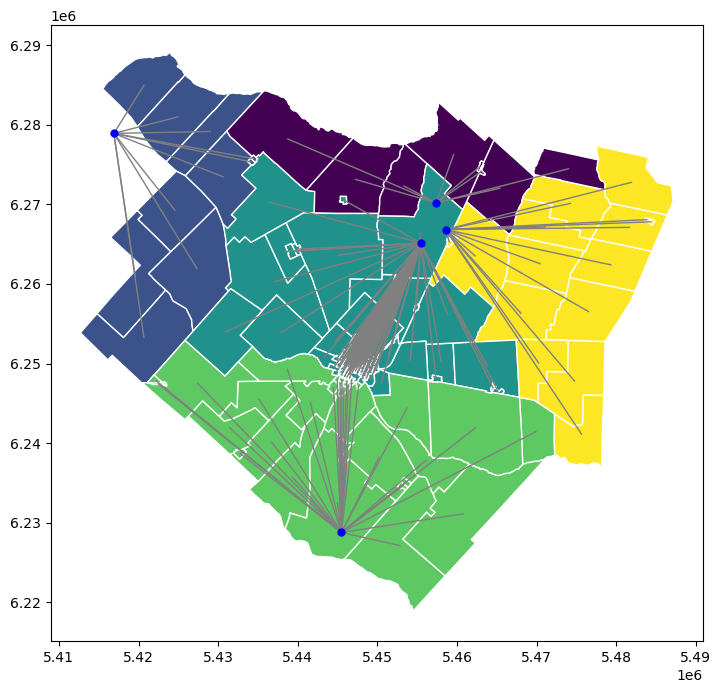

In [6]:
## Reutilizamos el cálculo de distancia de la clase 6 con algunas modificaciones
from shapely.ops import nearest_points
from shapely.geometry import LineString

# Crear una lista para almacenar las distancias al clúster más cercano
conexiones = []

# Iterar sobre los radios_censales y calcular la distancia al clúster más cercano
for idx, radio in radios_censales.iterrows():
    radio_geom = radio.geometry.centroid
    centroide_mas_cercana_idx = nearest_points(radio_geom, centroides_clusters.unary_union)[1]
    centroide_mas_cercana = centroides_clusters[centroides_clusters.geometry == centroide_mas_cercana_idx].iloc[0]
    etiqueta_centroide_cercana = centroide_mas_cercana['cluster']
    radios_censales.at[idx, 'cluster'] = etiqueta_centroide_cercana
    linea_entre_puntos = LineString([radio_geom, centroide_mas_cercana_idx])
    conexiones.append(linea_entre_puntos)

# Convierte la lista de conexiones a un GeoDataFrame para visualizarla
conexiones_gdf = gpd.GeoDataFrame(geometry=conexiones, crs=radios_censales.crs)

# Mostramos ambos conjuntos de datos
ax = radios_censales.plot(edgecolor='white', column='cluster', figsize=(10, 8), zorder=1)
conexiones_gdf.plot(ax=ax, color='gray', linewidth=1, zorder=1)
centroides_clusters.plot(ax=ax, color='blue', markersize=25, zorder=2)

#### Paso 3 - Actualización de Centroides
Calculamos el promedio de coordenadas de cada clúster para eso podemos utilizar el método `dissolve` visto en la clase anterior.

In [7]:
# Agrupar por el campo 'cluster' y calculamos el promedio de coordenadas
radios_censales_dissolve = radios_censales.dissolve(by='cluster')
reposicion_centroides_clusters = radios_censales_dissolve.centroid
reposicion_centroides_clusters = gpd.GeoDataFrame({'geometry': reposicion_centroides_clusters}, crs=reposicion_centroides_clusters.crs)


# Realizar una operación de unión 1 a 1 basada en un índice común
centroides_clusters = centroides_clusters.merge(reposicion_centroides_clusters, how='left', on='cluster')
centroides_clusters

,geometry_x,cluster,geometry_y
0,POINT (5457369.071 6270185.904),0,POINT (5452817.565 6274936.729)
1,POINT (5416898.918 6278899.788),1,POINT (5424490.665 6268634.440)
2,POINT (5455439.689 6265130.486),2,POINT (5446626.617 6259000.044)
3,POINT (5445484.425 6228781.107),3,POINT (5448548.688 6238302.505)
4,POINT (5458578.324 6266816.539),4,POINT (5473311.606 6259859.933)


<Axes: >

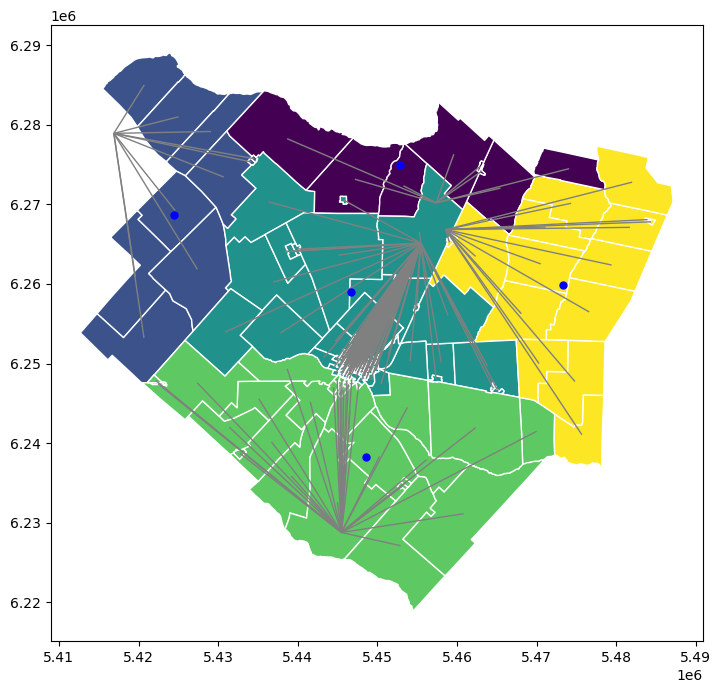

In [8]:
# Asignar las geometrías de los centroides a los puntos
centroides_clusters['geometry'] = centroides_clusters['geometry_y'].fillna(centroides_clusters['geometry_x'])

# Borrar las geometrías antiguas y setear de nuevo la geometry
centroides_clusters = centroides_clusters.drop(columns=['geometry_x','geometry_y'])
centroides_clusters = centroides_clusters.set_geometry('geometry')

# Mostramos ambos conjuntos de datos
ax = radios_censales.plot(edgecolor='white', column='cluster', figsize=(10, 8), zorder=1)
conexiones_gdf.plot(ax=ax, color='gray', linewidth=1, zorder=1)
centroides_clusters.plot(ax=ax, color='blue', markersize=25, zorder=2)

#### Paso 4 - Reasignación de puntos
Reutilizamos el paso 2

<Axes: >

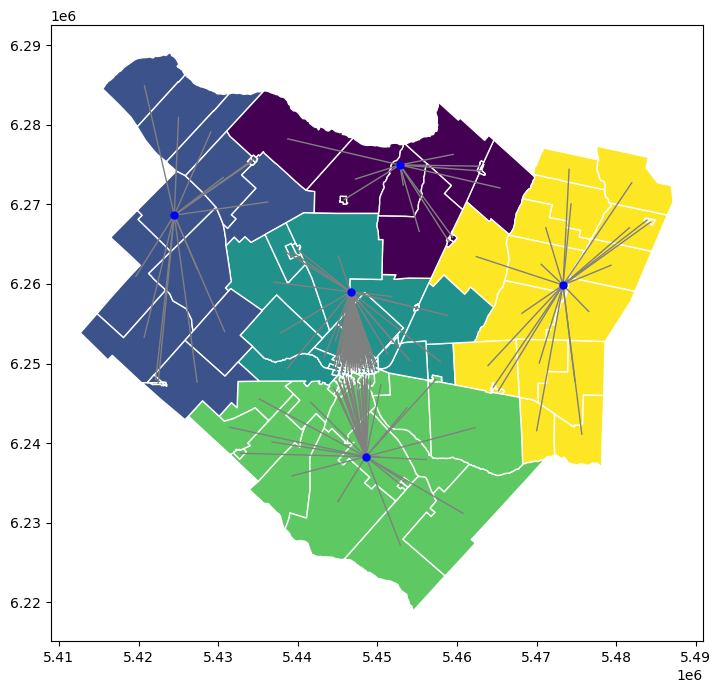

In [9]:
# Crear una lista para almacenar las distancias al clúster más cercano
conexiones = []

# Iterar sobre los radios_censales y calcular la distancia al río más cercano
for idx, radio in radios_censales.iterrows():
    radio_geom = radio.geometry.centroid
    centroide_mas_cercana_idx = nearest_points(radio_geom, centroides_clusters.unary_union)[1]
    centroide_mas_cercana = centroides_clusters[centroides_clusters.geometry == centroide_mas_cercana_idx].iloc[0]
    etiqueta_centroide_cercana = centroide_mas_cercana['cluster']
    radios_censales.at[idx, 'cluster'] = etiqueta_centroide_cercana
    linea_entre_puntos = LineString([radio_geom, centroide_mas_cercana_idx])
    conexiones.append(linea_entre_puntos)

# Convierte la lista de conexiones a un GeoDataFrame para visualizarla
conexiones_gdf = gpd.GeoDataFrame(geometry=conexiones, crs=radios_censales.crs)

# Mostramos ambos conjuntos de datos
ax = radios_censales.plot(edgecolor='white', column='cluster', figsize=(10, 8), zorder=1)
conexiones_gdf.plot(ax=ax, color='gray', linewidth=1, zorder=1)
centroides_clusters.plot(ax=ax, color='blue', markersize=25, zorder=2)

#### Paso 5 - Iteración
Comienza la iteración hasta que se cumplan los parámetros de convergencia.

### Aplicando K-means con sklearn
Sklearn trae una implementación de K-means para ser utilizada de manera muy práctica, la veremos a continuación:

In [10]:
# Volvemos a tomar la capa de radios censales y nos quedaremos con su geometría
radios_censales = radios_censales[['geometry']]

# Calculamos las coordenadas X e Y de su centroide
radios_censales['X'] = radios_censales.geometry.centroid.x
radios_censales['Y'] = radios_censales.geometry.centroid.y

# Creamos un DataFrame eliminando la columna geometry. Es necesario para aplicar KMeans
radios_censales_df = radios_censales.drop(columns='geometry')

# Mostramos el resultado
radios_censales_df

,X,Y
0,5.446139e+06,6.250486e+06
1,5.447266e+06,6.249815e+06
2,5.420722e+06,6.284994e+06
3,5.425030e+06,6.280987e+06
4,5.465461e+06,6.272031e+06
...,...,...
173,5.449822e+06,6.249165e+06
174,5.447343e+06,6.252298e+06
175,5.446324e+06,6.249952e+06
176,5.446597e+06,6.250482e+06


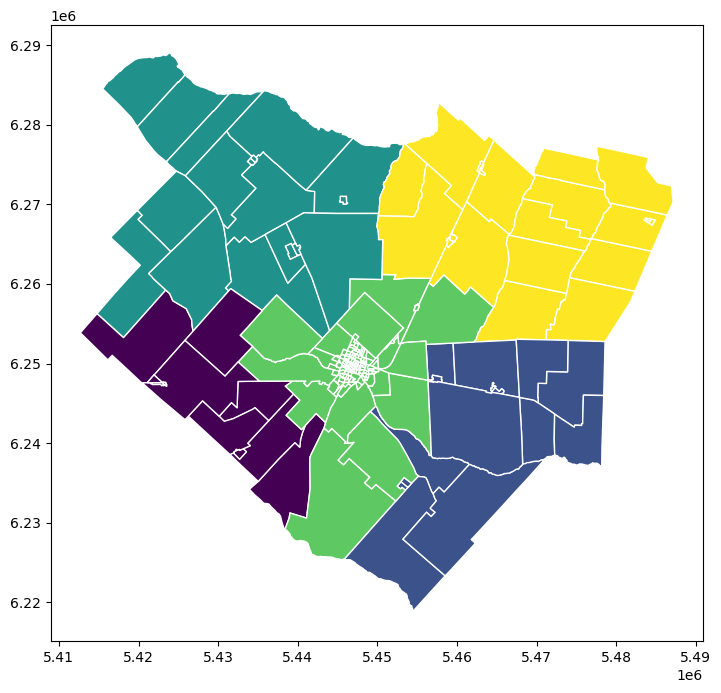

In [11]:
from sklearn.cluster import KMeans

# Cantidad de clúster a formar
num_cluster = 5

# Creamos el objeto KMeans con una configuración inicial
kmeans_radios = KMeans(n_clusters=num_cluster, n_init=1)  # max_iter=300, tol=0.0001

# Entrenamos y predecimos. Las clases se guardan en radios censales (GeoDataFrame)
radios_censales['cluster'] = kmeans_radios.fit_predict(radios_censales_df)

# Visualizamos el resultado
ax = radios_censales.plot(edgecolor='white', column='cluster', figsize=(10, 8), zorder=1)

## Geocodificación
La geocodificación es el proceso de convertir descripciones de ubicaciones (como direcciones postales o nombres de lugares) en coordenadas geográficas (como latitud y longitud). En otras palabras, es el proceso de asignar información espacial a datos basados en texto o nombres de lugares. Esto permite representar esos datos en un mapa y realizar análisis espaciales.

La geocodificación se realiza a menudo utilizando servicios de geocodificación que utilizan bases de datos y algoritmos para realizar la correspondencia entre descripciones de ubicaciones y coordenadas geográficas. Estos servicios pueden ser proporcionados por proveedores de mapas, organizaciones gubernamentales u otras fuentes de datos geográficos.


In [13]:
!pip install geopy

In [15]:
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

my_address = '644, 9 de Julio, Municipio de Córdoba, Córdoba, Argentina'

# Inicializamos el geolocalizador
geolocator = Nominatim(user_agent="clase_unab") # Cambiar nombre para que Nominatium tenga un identificación del usuario

# Consulta a Nominatim
try:
    ubicacion = geolocator.geocode(my_address, timeout=None) # timeout=None para no darle límite
    print('Latitud: ',ubicacion.latitude)
    print('Longitud: ',ubicacion.longitude)
    print('Dir. Normalizada: ',ubicacion.address)
except GeocoderTimedOut as e:
    print("Error: Falló la geocodificación de la entrada: %s con el mensaje %s"%(my_address, e.message))

Latitud:  -31.41224299375
Longitud:  -64.19240666875
Dir. Normalizada:  644, 9 de Julio, Alberdi, Córdoba, Municipio de Córdoba, Pedanía Capital, Departamento Capital, Córdoba, X5000, Argentina


In [16]:
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

# Cargamos direcciones desde un archivo CSV (asegurarse del separador de campos)
listado_direcciones = pd.read_csv("data/direcciones.csv", sep=";")

# Crear una instancia del geocodificador de Nominatim
geolocator = Nominatim(user_agent="clase_unab")

# Función para geocodificar una dirección y manejar errores
def geocodificar_direccion(direccion):
    try:
        ubicacion = geolocator.geocode(direccion, timeout=None)
        if ubicacion:
            latitud = ubicacion.latitude
            longitud = ubicacion.longitude
            direccion_normalizada = ubicacion.address
        else:
            latitud = None
            longitud = None
            direccion_normalizada = ''
    
    except GeocoderTimedOut as e:
        print(f"Error geocodificando '{direccion}': {e.message}")
        latitud = None
        longitud = None
        direccion_normalizada = ''  
    return(latitud, longitud, direccion_normalizada)

# Geocodificar las direcciones y agregar columnas al DataFrame original. Controlar que exista el campo 'dirección' en el DataFrame original
listado_direcciones['latitud'], listado_direcciones['longitud'], listado_direcciones['direccion_normalizada'] = zip(*listado_direcciones['direccion'].apply(geocodificar_direccion))

# Visualización de resultados
listado_direcciones



,id,direccion,latitud,longitud,direccion_normalizada
0,1,"366, Jujuy, Municipio de Córdoba, Córdoba, Arg...",-31.409839,-64.189062,"366, Jujuy, Centro, Córdoba, Municipio de Córd..."
1,2,"53, San Jerónimo, Municipio de Córdoba, Córdob...",-31.418212,-64.178879,"53, San Jerónimo, Centro, Córdoba, Municipio d..."
2,3,"66, Sucre, Municipio de Córdoba, Córdoba, Arge...",-31.413745,-64.189090,"66, Sucre, Centro, Córdoba, Municipio de Córdo..."
3,4,"644, 9 de Julio, Municipio de Córdoba, Córdoba...",-31.412243,-64.192407,"644, 9 de Julio, Alberdi, Córdoba, Municipio d..."


In [17]:
# Convierte la lista de conexiones a un GeoDataFrame para visualizarla
listado_direcciones_gdf = gpd.GeoDataFrame(listado_direcciones, 
                                           geometry=gpd.points_from_xy(listado_direcciones['longitud'], listado_direcciones['latitud']), 
                                           crs="EPSG:4326") # WGS 84

# Visualización
listado_direcciones_gdf.explore()